In [1]:
import numpy as np
import string 
import scipy.io
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
import itertools
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import *



class Scan(object):
    def __init__(self,activations,timestamp, step,prev_words=None,next_words=None,all_words=None,all_pos=None,all_speak_features=None,current_translated_words=None):
        self.activations = activations
        self.timestamp = timestamp
        self.prev_words = prev_words
        self.next_words = next_words
        self.step = step
        self.all_words = all_words
        self.current_translated_words = current_translated_words
        self.all_pos = all_pos
        self.all_speak_features = all_speak_features
        self.brain3d = None
        
        
        
subject_id = 1



In [2]:
subject_id = 1
fMRI_preprocessing_mode = "none"#"detrend_filter_std" 
block_scans = np.load("../processed_data/"+"subject_"+str(subject_id)+"/"+fMRI_preprocessing_mode+"subject_"+str(subject_id)+"_scan_objects.npy").item()

In [3]:
for i in np.arange(len(block_scans[1])):
    print(block_scans[1][i].all_words)
    print(block_scans[1][i].all_speak_features)

['Harry', 'had', 'never', 'believed']
[array([0, 0], dtype=uint8), array([0, 0], dtype=uint8), array([0, 0], dtype=uint8), array([0, 0], dtype=uint8)]
['he', 'would', 'meet', 'a']
[array([0, 0], dtype=uint8), array([0, 0], dtype=uint8), array([0, 0], dtype=uint8), array([0, 0], dtype=uint8)]
['boy', 'he', 'hated', 'more']
[array([0, 0], dtype=uint8), array([0, 0], dtype=uint8), array([0, 0], dtype=uint8), array([0, 0], dtype=uint8)]
['than', 'Dudley,', 'but', 'that']
[array([0, 0], dtype=uint8), array([0, 0], dtype=uint8), array([0, 0], dtype=uint8), array([0, 0], dtype=uint8)]
['was', 'before', 'he', 'met']
[array([0, 0], dtype=uint8), array([0, 0], dtype=uint8), array([0, 0], dtype=uint8), array([0, 0], dtype=uint8)]
['Draco', 'Malfoy.', 'Still,', 'first-year']
[array([0, 0], dtype=uint8), array([0, 0], dtype=uint8), array([0, 0], dtype=uint8), array([0, 0], dtype=uint8)]
['Gryffindors', 'only', 'had', 'Potions']
[array([0, 0], dtype=uint8), array([0, 0], dtype=uint8), array([0, 0], 

In [4]:
story_features = scipy.io.loadmat('../data/story_features.mat') 
subject_file = scipy.io.loadmat('../data/'+'subject_'+str(subject_id)+'.mat') 

word_index = 0
time_index = 1

speach_feature_id = 1
motion_feature_id = 2
emotion_feature_id = 3
verbs_feature_id = 4
characters_feature_id = 5
visual_wordlength_feature_id = 6
Word_Num_feature_id = 7
part_of_speaches_feature_id = 8
Dependency_role_feature_id = 9

In [5]:
part_of_speaches_feature_id = 8
speach_feature_id = 1
part_of_speaches = story_features['features'][0][part_of_speaches_feature_id][1][0]
part_of_speaches_features = story_features['features'][0][part_of_speaches_feature_id][2]
speaches = story_features['features'][0][speach_feature_id][1][0]
speach_features = story_features['features'][0][speach_feature_id][2]

In [6]:
print(len(speach_features))
print(len(subject_file['words'][0]))

5176
5176


In [55]:
actual_words = []
word_times = []
word_pos = []
speach_states = []
for i in np.arange(subject_file['words'].shape[1]):
    actual_words.append(subject_file['words'][0][i][word_index][0][0][0].strip().replace("@",""))
    word_times.append(subject_file['words'][0][i][time_index][0][0])
    word_pos.append(part_of_speaches_features[i])
    speach_states.append(speach_features[i])
    
    
blocks = subject_file['time'][:,1]
scan_times = subject_file['time'][:,0]

block_ends = {}
block_ends_indexes = {}


for block_id in np.arange(1,5):
    block_ends_indexes[block_id] = np.where(scan_times == np.max(scan_times[np.where(blocks == block_id )]))[0]
    block_ends[block_id] = scan_times[block_ends_indexes[block_id]]+2


print(block_ends)
print(block_ends_indexes)

block_texts = {1:[],2:[],3:[],4:[]}
block_pos = {1:[],2:[],3:[],4:[]}
block_speach_state = {1:[],2:[],3:[],4:[]}
block_steps = {1:[],2:[],3:[],4:[]}
character_feature = {1:[],2:[],3:[],4:[]}
pos_feature = {1:[],2:[],3:[],4:[]}
block_id = 1
for index in np.arange(len(actual_words)):
    if word_times[index] > block_ends[block_id]:
        block_id += 1
    block_texts[block_id].append(str(actual_words[index].encode("ascii",'ignore').decode()))
    block_pos[block_id].append(word_pos[index])
    pos_feature[block_id].append(np.argmax(word_pos[index]))
    block_speach_state[block_id].append(speach_states[index])
    block_steps[block_id].append(index)
    if max(story_features['features'][0][characters_feature_id][2][index]) == 0:
        character_feature[block_id].append(0)
    else:
        character_feature[block_id].append(1+np.argmax(story_features['features'][0][characters_feature_id][2][index]))

{1: array([680], dtype=uint16), 2: array([1384], dtype=uint16), 3: array([1942], dtype=uint16), 4: array([2702], dtype=uint16)}
{1: array([339]), 2: array([691]), 3: array([970]), 4: array([1350])}


In [8]:
for l in list(zip(speach_features,subject_file['words'][0][0])):
    print(l)

np.asarray(actual_words)[np.where(np.asarray(speach_states)[:,0] == 1)]

(array([0, 0], dtype=uint8), array([[array(['Harry'], dtype='<U5')]], dtype=object))
(array([0, 0], dtype=uint8), array([[20]], dtype=uint8))
(array([0, 0], dtype=uint8), array([[0.5]]))


array(['made', '"Typical,"', '"Just', 'To', '"You', '"Anyway,', '"Gran',
       'Look,', 'His', "you've", '"What\'s', '"Malfoy\'s', '"Just',
       '"Well,', 'she', '"Stick', '"UP!"', 'voice', '"Now,', '"Keep',
       'On', '"Come', '"Broken', '"Come', '"None', 'You', 'Come', '"Did',
       'joined', '"Shut', '"Ooh,', '"Never', '"Look!"', '"It\'s', '"Give',
       '"I', '"Give', '"Come', '"No!"', '"Madam', '"Give', '"Oh,', '"No',
       '"Catch', '"HARRY', '"Never', '"It', '"Be', '"But', '"That\'s',
       'Potter,', '"Excuse', '"Follow', '"In', '"Out,', '"Potter,',
       'Wood', '"Are', '"Absolutely,"', '"The', "I've", 'Was', 'caught',
       '"Didn\'t', 'Charlie', '"Ever', '"Wood\'s', '"He\'s', '"Light',
       '"I', 'Heaven', 'Flattened', '"I', '"Your', '"He', '"You\'re',
       '"Seeker?"', '"But', '"Wood', '"I', '"Only', '"Well', '"Wood',
       "We're", '"I', '"We', 'You', '"Anyway,', '"Bet', 'See', '"Having',
       '"You\'re', '"I\'d', '"Tonight,', "Wizard's", 'Wands', "What's

In [9]:
len(actual_words)

5176

In [10]:
LSTM_embeddings_H_0 = {1:[],2:[],3:[],4:[]}
LSTM_embeddings_H_1 = {1:[],2:[],3:[],4:[]}
LSTM_embeddings_H_01 = {1:[],2:[],3:[],4:[]}
LSTM_embeddings_M_0 = {1:[],2:[],3:[],4:[]}
LSTM_embeddings_M_1 = {1:[],2:[],3:[],4:[]}
LSTM_embeddings_M_01 = {1:[],2:[],3:[],4:[]}
LSTM_all = {1:[],2:[],3:[],4:[]}

for block_id in [1,2,3,4]:    
    print("block id",block_id)
    layer_id = 0
    lstm_h_0 = np.load("../../lm1b/text_input_full_state/block_"+str(block_id)+"/lstm_hidden_"+str(layer_id)+".npy")
    lstm_c_0 = np.load("../../lm1b/text_input_full_state/block_"+str(block_id)+"/lstm_memory_"+str(layer_id)+".npy")
    layer_id = 1
    lstm_h_1 = np.load("../../lm1b/text_input_full_state/block_"+str(block_id)+"/lstm_hidden_"+str(layer_id)+".npy")
    lstm_c_1 = np.load("../../lm1b/text_input_full_state/block_"+str(block_id)+"/lstm_memory_"+str(layer_id)+".npy")
  
    for step in np.arange(len(block_texts[block_id])):
        LSTM_embeddings_H_0[block_id].append(lstm_h_0.item()[step][0])
        LSTM_embeddings_H_1[block_id].append(lstm_h_1.item()[step][0])
        LSTM_embeddings_H_01[block_id].append(np.concatenate([lstm_h_0.item()[step][0],lstm_h_1.item()[step][0]]))
        
        LSTM_embeddings_M_0[block_id].append(lstm_c_0.item()[step][0])
        LSTM_embeddings_M_1[block_id].append(lstm_c_1.item()[step][0])
        LSTM_embeddings_M_01[block_id].append(np.concatenate([lstm_c_0.item()[step][0],lstm_c_1.item()[step][0]]))
        LSTM_all[block_id].append(np.concatenate([lstm_c_0.item()[step][0],lstm_h_0.item()[step][0],lstm_c_1.item()[step][0],lstm_h_1.item()[step][0]]))
        
        
        
        

block id 1
block id 2
block id 3
block id 4


In [11]:
np.asarray(LSTM_embeddings_H_0[4]).shape

(1463, 1024)

In [12]:
for block_id in [1,2,3,4]:
    print(len(LSTM_embeddings_H_0[block_id]),len(block_speach_state[block_id]),len(block_texts[block_id]))

1303 1303 1303
1351 1351 1351
1059 1059 1059
1463 1463 1463


In [13]:
full_text_blocks = {}
for block_id in [1,2,3,4]:
    full_text_blocks[block_id] = ' '.join(block_texts[block_id])
    with open("../text_input/block_"+str(block_id)+"_rawtext.txt","w") as fout:
        fout.write(full_text_blocks[block_id])

In [14]:
import re
import string

end_of_sentence_indexes = {1:[],2:[],3:[],4:[]}
start_of_sentence_indexes = {1:[],2:[],3:[],4:[]}
qout_indexes = {1:[],2:[],3:[],4:[]}
inside_qout_indexes = {1:[],2:[],3:[],4:[]}

for block_id in [1,2,3,4]:
    start_of_sentence_indexes[block_id].append(0)
    inside_qout = False
    for i in np.arange(len(block_texts[block_id])):
        
        already_in = False   
        if "\"" in block_texts[block_id][i]:
            qout_indexes[block_id].append(i)
            
            checked = False
            if block_texts[block_id][i].strip().startswith("\""):
                if inside_qout is False :
                    if already_in == False:
                        inside_qout_indexes[block_id].append(i)
                        already_in = True
                inside_qout = not inside_qout
                checked = True
                
            if block_texts[block_id][i].strip().endswith("\""):
                if inside_qout is True :
                    if already_in == False:
                        inside_qout_indexes[block_id].append(i) 
                        already_in = True
                inside_qout = not inside_qout
                checked = True
                
            if checked == False:
                print(block_texts[block_id][i])
                
        if inside_qout:
            if already_in == False:
                inside_qout_indexes[block_id].append(i)
        #end/start of sentence
        truth_table = [punc in block_texts[block_id][i] for punc in ["!",".","?",":"]]
        if True in truth_table:
            end_of_sentence_indexes[block_id].append(i)
            if i+1 < len(block_texts[block_id]):
                start_of_sentence_indexes[block_id].append(i+1)
        

In [15]:
print(end_of_sentence_indexes[1])
print(start_of_sentence_indexes[1])
print(qout_indexes[1])
print(inside_qout_indexes[1])

[21, 40, 62, 78, 83, 88, 101, 115, 128, 148, 157, 187, 193, 212, 232, 240, 256, 276, 294, 314, 338, 350, 368, 392, 430, 450, 470, 482, 506, 510, 512, 528, 583, 591, 620, 624, 630, 641, 656, 681, 725, 743, 775, 781, 792, 800, 802, 807, 811, 818, 831, 849, 851, 853, 871, 886, 920, 946, 962, 979, 997, 1030, 1034, 1056, 1098, 1119, 1132, 1138, 1148, 1157, 1172, 1190, 1193, 1212, 1225, 1234, 1240, 1247, 1253, 1260, 1268, 1270, 1281, 1289, 1301]
[0, 22, 41, 63, 79, 84, 89, 102, 116, 129, 149, 158, 188, 194, 213, 233, 241, 257, 277, 295, 315, 339, 351, 369, 393, 431, 451, 471, 483, 507, 511, 513, 529, 584, 592, 621, 625, 631, 642, 657, 682, 726, 744, 776, 782, 793, 801, 803, 808, 812, 819, 832, 850, 852, 854, 872, 887, 921, 947, 963, 980, 998, 1031, 1035, 1057, 1099, 1120, 1133, 1139, 1149, 1158, 1173, 1191, 1194, 1213, 1226, 1235, 1241, 1248, 1254, 1261, 1269, 1271, 1282, 1290, 1302]
[80, 84, 101, 116, 125, 129, 148, 508, 510, 513, 543, 554, 558, 622, 624, 626, 630, 643, 644, 794, 800, 803, 

In [16]:
np.asarray(block_texts[1])[85]

'what'

In [17]:
inside_qout_feature = {1:[],2:[],3:[],4:[]}
start_sentence_feature = {1:[],2:[],3:[],4:[]}
end_sentence_feature = {1:[],2:[],3:[],4:[]}
for block_id in [1,2,3,4]:
    inside_qout_feature[block_id] = np.zeros((len(block_texts[block_id])))
    inside_qout_feature[block_id][inside_qout_indexes[block_id]] = 1
    
    start_sentence_feature[block_id] = np.zeros((len(block_texts[block_id])))
    start_sentence_feature[block_id][start_of_sentence_indexes[block_id]] = 1

    end_sentence_feature[block_id] = np.zeros((len(block_texts[block_id])))
    end_sentence_feature[block_id][end_of_sentence_indexes[block_id]] = 1
    
def get_fold(blocked_inputs, blocked_labels, blocks):
    all_inputs = []
    all_labels = []
    for b in blocks:
        for i,o in zip(blocked_inputs[b],blocked_labels[b]):
            all_inputs.append(i)
            all_labels.append(o)

    print("folding shapes:",np.asarray(all_inputs).shape,np.asarray(all_labels).shape)
    return np.asarray(all_inputs),np.asarray(all_labels)
    

Predicting end of the sentence:

In [ ]:
x_train, y_train = get_fold(LSTM_embeddings_H_0,end_sentence_feature,[1,2,3])
x_test, y_test = get_fold(LSTM_embeddings_H_0,end_sentence_feature,[4])

print(x_train.shape,y_train.shape)
clf = SVC()
clf.fit(x_train, y_train)

prediction_train = clf.predict(x_train)
prediction_test = clf.predict(x_test)

train_accuracy = np.mean(y_train == prediction_train)
test_accuracy = np.mean(y_test == prediction_test)

print("train accuracy: ",train_accuracy, " test accuracy: ",test_accuracy)

In [ ]:
Predicting start of sentence:

In [ ]:
x_train, y_train = get_fold(LSTM_embeddings_H_1,start_sentence_feature,[1,2,3])
x_test, y_test = get_fold(LSTM_embeddings_H_1,start_sentence_feature,[4])

clf = SVC(kernel='linear')
clf.fit(x_train, y_train)

prediction_train = clf.predict(x_train)
prediction_test = clf.predict(x_test)

train_accuracy = np.mean(y_train == prediction_train)
test_accuracy = np.mean(y_test == prediction_test)

print("train accuracy: ",train_accuracy, " test accuracy: ",test_accuracy)
print(len(clf.coef_[0]))

In [ ]:
import matplotlib.pyplot as plt
sort_index = np.argsort(clf.coef_[0])
plt.plot(np.arange(len(clf.coef_[0])),clf.coef_[0][sort_index])
plt.ylabel('some numbers')
plt.show()

predicting inside qout:

In [77]:
def evaluate_a_fold(train_blocks, test_blocks,inputs,labels,C=0.01,number_of_classes=2):
    x_train, y_train = get_fold(inputs,labels,train_blocks)
    x_test, y_test = get_fold(inputs,labels,test_blocks)

    
    if x_train.shape[1] > 512:
        pca_x = PCA(n_components=512)
        pca_x.fit(x_train)

        x_train = pca_x.transform(x_train)
        x_test = pca_x.transform(x_test)
    
    print(x_train.shape,y_train.shape)
    clf = SVC(kernel='linear', C=C, probability = True,class_weight='balanced')
    clf.fit(x_train, y_train)

    prediction_train = clf.predict(x_train)
    prediction_test = clf.predict(x_test)
    
    prob_prediction_train = clf.predict_proba(x_train)
    prob_prediction_test = clf.predict_proba(x_test)

    train_accuracy = np.mean(y_train == prediction_train)
    test_accuracy = np.mean(y_test == prediction_test)

    print("train accuracy: ",train_accuracy, " test accuracy: ",test_accuracy)
    cnf_matrix = confusion_matrix(y_test, prediction_test)
    print(cnf_matrix)
    
   
    result = []
    imp_acc = []
    for i in np.arange(len(prob_prediction_test)):
        if y_test[i] > 0:
            j = np.where (np.argsort(prob_prediction_test[i]) == np.asarray(y_test[i]))[0]
            if len(j) < 0:
                result.append(1/(number_of_classes - j[0]))
            else:
                result.append(1/(number_of_classes))
            imp_acc.append(prediction_test[i] == y_test[i])
    
    print("MRR: ",np.mean(result),"Imp Acc:",np.mean(imp_acc))
    
    return clf.coef_[0]



In [30]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_0,start_sentence_feature)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_0,start_sentence_feature)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_0,start_sentence_feature)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_0,start_sentence_feature)

folding shapes: (3713, 1024) (3713,)
folding shapes: (1463, 1024) (1463,)
(3713, 1024) (3713,)
train accuracy:  1.0  test accuracy:  0.9972658920027341
[[1336    0]
 [   4  123]]
MRR:  0.984251968503937 Imp Acc: 0.968503937007874
folding shapes: (3873, 1024) (3873,)
folding shapes: (1303, 1024) (1303,)
(3873, 1024) (3873,)
train accuracy:  1.0  test accuracy:  0.9984650805832693
[[1216    1]
 [   1   85]]
MRR:  0.9941860465116279 Imp Acc: 0.9883720930232558
folding shapes: (3825, 1024) (3825,)
folding shapes: (1351, 1024) (1351,)
(3825, 1024) (3825,)
train accuracy:  1.0  test accuracy:  0.9985196150999259
[[1235    0]
 [   2  114]]
MRR:  0.9913793103448276 Imp Acc: 0.9827586206896551
folding shapes: (4117, 1024) (4117,)
folding shapes: (1059, 1024) (1059,)
(4117, 1024) (4117,)
train accuracy:  1.0  test accuracy:  0.9981114258734656
[[961   0]
 [  2  96]]
MRR:  0.9897959183673469 Imp Acc: 0.9795918367346939


In [31]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_1,start_sentence_feature)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_1,start_sentence_feature)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_1,start_sentence_feature)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_1,start_sentence_feature)

folding shapes: (3713, 1024) (3713,)
folding shapes: (1463, 1024) (1463,)
(3713, 1024) (3713,)
train accuracy:  0.9994613520064638  test accuracy:  0.9938482570061518
[[1336    0]
 [   9  118]]
MRR:  0.9566929133858267 Imp Acc: 0.9133858267716536
folding shapes: (3873, 1024) (3873,)
folding shapes: (1303, 1024) (1303,)
(3873, 1024) (3873,)
train accuracy:  0.9987090111025045  test accuracy:  0.9961627014581734
[[1215    2]
 [   3   83]]
MRR:  0.9825581395348837 Imp Acc: 0.9651162790697675
folding shapes: (3825, 1024) (3825,)
folding shapes: (1351, 1024) (1351,)
(3825, 1024) (3825,)
train accuracy:  0.9992156862745099  test accuracy:  0.9955588452997779
[[1232    3]
 [   3  113]]
MRR:  0.9827586206896551 Imp Acc: 0.9655172413793104
folding shapes: (4117, 1024) (4117,)
folding shapes: (1059, 1024) (1059,)
(4117, 1024) (4117,)
train accuracy:  0.9992713140636386  test accuracy:  0.987724268177526
[[957   4]
 [  9  89]]
MRR:  0.9489795918367347 Imp Acc: 0.8979591836734694


In [69]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_H_1,end_sentence_feature,C=0.01)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_H_1,end_sentence_feature,C=0.01)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_H_1,end_sentence_feature,C=0.01)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_H_1,end_sentence_feature,C=0.01)

folding shapes: (3713, 1024) (3713,)
folding shapes: (1463, 1024) (1463,)
(3713, 1024) (3713,)
train accuracy:  0.8564503097225963  test accuracy:  0.7573479152426521
[[1050  287]
 [  68   58]]
MRR:  0.5 Imp Acc: 0.4603174603174603
folding shapes: (3873, 1024) (3873,)
folding shapes: (1303, 1024) (1303,)
(3873, 1024) (3873,)
train accuracy:  0.838884585592564  test accuracy:  0.6768994627782041
[[830 388]
 [ 33  52]]
MRR:  0.5 Imp Acc: 0.611764705882353
folding shapes: (3825, 1024) (3825,)
folding shapes: (1351, 1024) (1351,)
(3825, 1024) (3825,)
train accuracy:  0.8650980392156863  test accuracy:  0.7505551443375278
[[962 274]
 [ 63  52]]
MRR:  0.5 Imp Acc: 0.45217391304347826
folding shapes: (4117, 1024) (4117,)
folding shapes: (1059, 1024) (1059,)
(4117, 1024) (4117,)
train accuracy:  0.8440612096186544  test accuracy:  0.7459867799811143
[[754 208]
 [ 61  36]]
MRR:  0.5 Imp Acc: 0.3711340206185567


In [70]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_0,end_sentence_feature,C=0.01)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_0,end_sentence_feature,C=0.01)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_0,end_sentence_feature,C=0.01)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_0,end_sentence_feature,C=0.01)

folding shapes: (3713, 8192) (3713,)
folding shapes: (1463, 8192) (1463,)
(3713, 2048) (3713,)
train accuracy:  0.9671424723942903  test accuracy:  0.8509911141490089
[[1221  116]
 [ 102   24]]
MRR:  0.5 Imp Acc: 0.19047619047619047
folding shapes: (3873, 8192) (3873,)
folding shapes: (1303, 8192) (1303,)
(3873, 2048) (3873,)
train accuracy:  0.9607539375161374  test accuracy:  0.8257866462010744
[[1056  162]
 [  65   20]]
MRR:  0.5 Imp Acc: 0.23529411764705882
folding shapes: (3825, 8192) (3825,)
folding shapes: (1351, 8192) (1351,)
(3825, 2048) (3825,)
train accuracy:  0.9639215686274509  test accuracy:  0.8519615099925981
[[1133  103]
 [  97   18]]
MRR:  0.5 Imp Acc: 0.1565217391304348
folding shapes: (4117, 8192) (4117,)
folding shapes: (1059, 8192) (1059,)
(4117, 2048) (4117,)
train accuracy:  0.9618654359970853  test accuracy:  0.830028328611898
[[854 108]
 [ 72  25]]
MRR:  0.5 Imp Acc: 0.25773195876288657


In [ ]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_1,end_sentence_feature,C=0.01)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_1,end_sentence_feature,C=0.01)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_1,end_sentence_feature,C=0.01)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_1,end_sentence_feature,C=0.01)

In [76]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_1,end_sentence_feature,C=0.1)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_1,end_sentence_feature,C=0.1)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_1,end_sentence_feature,C=0.1)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_1,end_sentence_feature,C=0.1)

folding shapes: (3713, 8192) (3713,)
folding shapes: (1463, 8192) (1463,)
(3713, 1024) (3713,)
train accuracy:  0.9622946404524643  test accuracy:  0.9090909090909091
[[1329    8]
 [ 125    1]]
MRR:  0.5 Imp Acc: 0.007936507936507936
folding shapes: (3873, 8192) (3873,)
folding shapes: (1303, 8192) (1303,)
(3873, 1024) (3873,)
train accuracy:  0.9486186418796798  test accuracy:  0.23944742900997698
[[236 982]
 [  9  76]]
MRR:  0.5 Imp Acc: 0.8941176470588236
folding shapes: (3825, 8192) (3825,)
folding shapes: (1351, 8192) (1351,)
(3825, 1024) (3825,)
train accuracy:  0.9555555555555556  test accuracy:  0.1376757957068838
[[  78 1158]
 [   7  108]]
MRR:  0.5 Imp Acc: 0.9391304347826087
folding shapes: (4117, 8192) (4117,)
folding shapes: (1059, 8192) (1059,)
(4117, 1024) (4117,)
train accuracy:  0.9455914500850133  test accuracy:  0.8876298394711992
[[937  25]
 [ 94   3]]
MRR:  0.5 Imp Acc: 0.030927835051546393


In [75]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_H_0,end_sentence_feature,C=0.001)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_H_0,end_sentence_feature,C=0.001)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_H_0,end_sentence_feature,C=0.001)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_H_0,end_sentence_feature,C=0.001)

folding shapes: (3713, 1024) (3713,)
folding shapes: (1463, 1024) (1463,)
(3713, 1024) (3713,)
train accuracy:  0.7093994074872071  test accuracy:  0.6739576213260424
[[916 421]
 [ 56  70]]
MRR:  0.5 Imp Acc: 0.5555555555555556
folding shapes: (3873, 1024) (3873,)
folding shapes: (1303, 1024) (1303,)
(3873, 1024) (3873,)
train accuracy:  0.6842241156726052  test accuracy:  0.6270145817344589
[[757 461]
 [ 25  60]]
MRR:  0.5 Imp Acc: 0.7058823529411765
folding shapes: (3825, 1024) (3825,)
folding shapes: (1351, 1024) (1351,)
(3825, 1024) (3825,)
train accuracy:  0.7090196078431372  test accuracy:  0.6765358993338267
[[842 394]
 [ 43  72]]
MRR:  0.5 Imp Acc: 0.6260869565217392
folding shapes: (4117, 1024) (4117,)
folding shapes: (1059, 1024) (1059,)
(4117, 1024) (4117,)
train accuracy:  0.6905513723585135  test accuracy:  0.6392823418319169
[[615 347]
 [ 35  62]]
MRR:  0.5 Imp Acc: 0.6391752577319587


In [ ]:
print(np.asarray(character_feature[4]).shape)
print(np.asarray(LSTM_embeddings_H_0[4]).shape)
max(character_feature[4])

In [42]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_H_0,character_feature,C=0.001,number_of_classes=11)

folding shapes: (3713, 1024) (3713,)
folding shapes: (1463, 1024) (1463,)
(3713, 1024) (3713,)
train accuracy:  0.6897387557231349  test accuracy:  0.596719070403281
[[847  61   0 170  64   8   7  94   0  53  20]
 [  2   0   0   2   2   0   1   0   0   0   1]
 [  2   4   1   9   2   2   0   3   0   1   0]
 [  7   2   0  17   3   0   1   3   0   7   2]
 [  6   0   0   6   3   0   0   2   0   3   3]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  1   1   0   5   0   0   0   1   0   0   0]
 [  5   3   0   6   2   0   0   0   0   3   1]
 [  5   1   0   2   2   0   0   0   0   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0]]
MRR:  0.26701573805890355 Imp Acc: 0.18705035971223022


In [45]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_H_0,character_feature,C=0.001,number_of_classes=11)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_H_0,character_feature,C=0.001,number_of_classes=11)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_H_0,character_feature,C=0.001,number_of_classes=11)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_H_0,character_feature,C=0.001,number_of_classes=11)

folding shapes: (3713, 1024) (3713,)
folding shapes: (1463, 1024) (1463,)
(3713, 1024) (3713,)
train accuracy:  0.6897387557231349  test accuracy:  0.596719070403281
[[847  61   0 170  64   8   7  94   0  53  20]
 [  2   0   0   2   2   0   1   0   0   0   1]
 [  2   4   1   9   2   2   0   3   0   1   0]
 [  7   2   0  17   3   0   1   3   0   7   2]
 [  6   0   0   6   3   0   0   2   0   3   3]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  1   1   0   5   0   0   0   1   0   0   0]
 [  5   3   0   6   2   0   0   0   0   3   1]
 [  5   1   0   2   2   0   0   0   0   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0]]
MRR:  0.09090909090909093 Imp Acc: 0.18705035971223022
folding shapes: (3873, 1024) (3873,)
folding shapes: (1303, 1024) (1303,)
(3873, 1024) (3873,)
train accuracy:  0.6762199845081333  test accuracy:  0.6845740598618573
[[873  17  23  98  33   0   9  62  14  36  13]
 [  8   5   1   4   1   0   0   2   1   3   0]


In [46]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_H_1,character_feature,C=0.001,number_of_classes=11)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_H_1,character_feature,C=0.001,number_of_classes=11)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_H_1,character_feature,C=0.001,number_of_classes=11)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_H_1,character_feature,C=0.001,number_of_classes=11)

folding shapes: (3713, 1024) (3713,)
folding shapes: (1463, 1024) (1463,)
(3713, 1024) (3713,)
train accuracy:  0.6137893886345274  test accuracy:  0.5700615174299385
[[813  35   3 178 151   8   8  81   0  45   2]
 [  2   0   0   1   5   0   0   0   0   0   0]
 [  1   1   0   9   8   0   0   3   0   2   0]
 [  7   5   0  10  12   0   0   3   0   5   0]
 [  4   3   0   2   8   0   0   2   0   2   2]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  1   2   0   2   2   0   0   1   0   0   0]
 [  1   2   0   6   5   0   2   0   0   4   0]
 [  2   2   0   3   5   0   0   0   0   2   0]
 [  0   0   0   0   0   0   0   0   0   0   0]]
MRR:  0.09090909090909093 Imp Acc: 0.1510791366906475
folding shapes: (3873, 1024) (3873,)
folding shapes: (1303, 1024) (1303,)
(3873, 1024) (3873,)
train accuracy:  0.6000516395558998  test accuracy:  0.6047582501918649
[[768  52   2 230  27   0  11  24   3  45  16]
 [  3   7   0   6   2   0   0   1   1   5   0]


In [47]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_0,character_feature,C=0.001,number_of_classes=11)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_0,character_feature,C=0.001,number_of_classes=11)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_0,character_feature,C=0.001,number_of_classes=11)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_0,character_feature,C=0.001,number_of_classes=11)

folding shapes: (3713, 8192) (3713,)
folding shapes: (1463, 8192) (1463,)
(3713, 2048) (3713,)
train accuracy:  0.6956638836520334  test accuracy:  0.5789473684210527
[[830  57   0 230  88   3  69   0  45   2]
 [  4   0   0   2   2   0   0   0   0   0]
 [  4   5   0   6   3   1   3   0   1   1]
 [ 13   2   0  12   8   0   2   0   5   0]
 [  6   2   1   8   2   0   1   0   3   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   7   0   0   0   0   1   0]
 [  4   2   0   6   3   0   2   0   3   0]
 [  3   1   0   5   1   0   1   0   3   0]
 [  0   0   0   0   0   0   0   0   0   0]]
MRR:  0.09090909090909093 Imp Acc: 0.1223021582733813
folding shapes: (3873, 8192) (3873,)
folding shapes: (1303, 8192) (1303,)
(3873, 2048) (3873,)
train accuracy:  0.6911954557190808  test accuracy:  0.6508058326937836
[[832  25  11 218  35   0  17   5   3  30   2]
 [  8   3   1   7   1   0   0   0   1   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  5   2   1   9   6   0   0   0   0   

In [ ]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_1,character_feature,C=0.01,number_of_classes=11)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_1,character_feature,C=0.01,number_of_classes=11)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_1,character_feature,C=0.01,number_of_classes=11)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_1,character_feature,C=0.01,number_of_classes=11)

In [ ]:
print(coef_1)
sort_index = np.argsort(coef_1)
plt.plot(np.arange(len(coef_1)),coef_1[sort_index],np.arange(len(coef_1)),coef_2[sort_index],
         np.arange(len(coef_1)),coef_3[sort_index],np.arange(len(coef_1)),coef_4[sort_index])

plt.show()

In [61]:
coef_1_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_H_0,pos_feature,C=0.01,number_of_classes=28)

folding shapes: (3713, 1024) (3713,)
folding shapes: (1463, 1024) (1463,)
(3713, 1024) (3713,)
train accuracy:  0.6269862644761648  test accuracy:  0.3362952836637047
[[57  4  2  5  0 10  7  7 10 18  6  6  0  8  2  4  2  2  0  5 17  4  0  1
   0  0  0  0]
 [ 4 16  3  9  2  8  8  7  4 12  4  9  0  3  4  3  2  1  0  5 14  3  2  0
   1  0  0  0]
 [ 0  4  0  6  0  1  7  1  2  0  1  1  0  0  0  0  0  2  0  0  1  0  0  1
   0  0  0  0]
 [ 2  1  3 22  3  1 10  0  1  1  1  0  0  0  1  0  0  0  0  0  1  1  1  0
   0  1  0  0]
 [ 0  1  1  1  0  1  0  0  0  1  1  1  0  1  0  0  0  0  0  0  3  0  1  0
   0  0  0  0]
 [ 6  4  0  4  1 49  3  3  4  0  7  1  0 10 11  0  3  1  0  3  2  2  0  0
   0  0  0  0]
 [ 5  3  1 17  1  3 63  3  3  3  1  1  0  4  6 13  3  8  0  1  9  5  0  0
   0  1  1  0]
 [ 1  0  0  1  0  1  2  5  0 20  1  4  0  2  2  1  0  0  0  1  0  5  0  0
   0  0  0  0]
 [ 1  0  0  3  0  1  0  1  3  1  1  0  0  1  0  0  0  0  0  0  5  0  0  1
   0  0  0  0]
 [ 0  6  1  3  0  6  0 13  1 44 

In [63]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_H_0,pos_feature,C=0.01,number_of_classes=28)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_H_0,pos_feature,C=0.01,number_of_classes=28)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_H_0,pos_feature,C=0.01,number_of_classes=28)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_H_0,pos_feature,C=0.01,number_of_classes=28)

print("############")

coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_H_1,pos_feature,C=0.01,number_of_classes=28)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_H_1,pos_feature,C=0.01,number_of_classes=28)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_H_1,pos_feature,C=0.01,number_of_classes=28)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_H_1,pos_feature,C=0.01,number_of_classes=28)

folding shapes: (3713, 1024) (3713,)
folding shapes: (1463, 1024) (1463,)
(3713, 1024) (3713,)
train accuracy:  0.6269862644761648  test accuracy:  0.3362952836637047
[[57  4  2  5  0 10  7  7 10 18  6  6  0  8  2  4  2  2  0  5 17  4  0  1
   0  0  0  0]
 [ 4 16  3  9  2  8  8  7  4 12  4  9  0  3  4  3  2  1  0  5 14  3  2  0
   1  0  0  0]
 [ 0  4  0  6  0  1  7  1  2  0  1  1  0  0  0  0  0  2  0  0  1  0  0  1
   0  0  0  0]
 [ 2  1  3 22  3  1 10  0  1  1  1  0  0  0  1  0  0  0  0  0  1  1  1  0
   0  1  0  0]
 [ 0  1  1  1  0  1  0  0  0  1  1  1  0  1  0  0  0  0  0  0  3  0  1  0
   0  0  0  0]
 [ 6  4  0  4  1 49  3  3  4  0  7  1  0 10 11  0  3  1  0  3  2  2  0  0
   0  0  0  0]
 [ 5  3  1 17  1  3 63  3  3  3  1  1  0  4  6 13  3  8  0  1  9  5  0  0
   0  1  1  0]
 [ 1  0  0  1  0  1  2  5  0 20  1  4  0  2  2  1  0  0  0  1  0  5  0  0
   0  0  0  0]
 [ 1  0  0  3  0  1  0  1  3  1  1  0  0  1  0  0  0  0  0  0  5  0  0  1
   0  0  0  0]
 [ 0  6  1  3  0  6  0 13  1 44 

folding shapes: (1463, 1024) (1463,)
(3713, 1024) (3713,)
train accuracy:  0.6337193643953676  test accuracy:  0.34791524265208473
[[59  5  3  9  0  6  5  7  4 14  5  4  0 12  7  1  3  3  5 19  3  0  2  0
   0  0  1]
 [ 5 15  2 11  1 11  6  9  4  8  2  7  1  7  2  0  4  3  5 12  1  7  1  0
   0  0  0]
 [ 0  1  1  6  0  0  5  1  2  0  1  1  0  3  0  0  0  2  1  1  0  0  1  0
   0  0  1]
 [ 2  1  1 30  1  2  4  0  0  0  1  1  0  3  0  0  0  0  0  3  1  0  0  0
   0  0  0]
 [ 1  0  0  0  0  2  2  1  1  0  0  1  0  0  0  0  0  0  0  3  0  1  0  0
   0  0  0]
 [ 7  4  1  3  0 52  4  2  1  0  6  1  0 16  6  0  2  2  2  2  2  1  0  0
   0  0  0]
 [ 5  1  1 26  0  3 57  4  2  3  1  2  0  5  6  6  4 10  0  9  5  0  2  0
   1  1  1]
 [ 0  0  0  2  0  3  3 12  1 11  0  5  0  0  1  1  1  0  1  0  4  1  0  0
   0  0  0]
 [ 1  0  0  2  0  0  2  0  1  0  1  0  0  3  0  0  0  0  0  7  0  0  1  0
   0  0  0]
 [ 0  3  0  3  0  6  1 11  1 43  2  9  0  1  2  1  0  0  0  2  0  0  0  2
   0  0  0]
 [ 7  5  

In [64]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_0,pos_feature,C=0.01,number_of_classes=28)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_0,pos_feature,C=0.01,number_of_classes=28)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_0,pos_feature,C=0.01,number_of_classes=28)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_0,pos_feature,C=0.01,number_of_classes=28)

print("############")

coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_1,pos_feature,C=0.01,number_of_classes=28)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_1,pos_feature,C=0.01,number_of_classes=28)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_1,pos_feature,C=0.01,number_of_classes=28)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_1,pos_feature,C=0.01,number_of_classes=28)

folding shapes: (3713, 8192) (3713,)
folding shapes: (1463, 8192) (1463,)
(3713, 2048) (3713,)
train accuracy:  0.858066253703205  test accuracy:  0.3267259056732741
[[52 14  2  2  0  7 14  5  1 13 11  1  0 17  2  5  0  2  6 18  3  1  1  0
   0  0  0]
 [ 7 23  3  6  0  9 16  9  1 10  4  3  0 12  0  1  0  1  5 11  2  1  0  0
   0  0  0]
 [ 3  2  0  2  0  1  9  0  1  1  1  0  0  3  0  0  0  1  0  2  0  0  1  0
   0  0  0]
 [ 2  2  0 14  1  5 15  0  0  2  0  0  0  2  1  1  1  0  0  1  1  0  0  0
   2  0  0]
 [ 1  1  1  1  0  2  2  1  1  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0]
 [ 7  9  0  1  0 48  5  2  2  2  6  0  0 15  8  1  0  1  3  2  2  0  0  0
   0  0  0]
 [ 9  7  0  7  1  6 75  1  1  3  0  1  0  9  2 11  3  3  2  6  6  0  0  0
   1  0  1]
 [ 1  6  0  3  0  2  5  7  0 12  0  1  0  3  0  2  0  0  0  1  3  0  0  0
   0  0  0]
 [ 0  0  0  1  0  1  1  0  1  0  2  0  0  3  1  1  0  0  0  5  0  0  2  0
   0  0  0]
 [ 2  9  0  4  0  8  3  7  0 42  1  2  0  4  1  0  0  0  0  

############
folding shapes: (3713, 8192) (3713,)
folding shapes: (1463, 8192) (1463,)
(3713, 2048) (3713,)
train accuracy:  0.6846215997845408  test accuracy:  0.07792207792207792
[[ 5  0  2  1 54  4  1  1  1  3  1  0  0  8  0  3  0  1  0  1  1 33  0  0
  35  0 22]
 [ 2  0  4  0 36  5  3  1  0  3  0  0  0  1  0  5  1  0  1  1  2 24  0  0
  27  0  8]
 [ 0  0  0  0  9  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  5  0  0
   5  0  5]
 [ 0  1  3  2  4  3  1  0  2  1  0  0  0  1  0  0  0  0  0  0  0  9  0  0
  12  0 11]
 [ 0  0  0  0  3  3  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0
   1  0  3]
 [ 1  0  2  0 39 21  1  0  1  0  1  0  0  4  0  0  0  0  0  0  0  9  0  0
  18  0 17]
 [ 0  0  4  3 38  7 17  0  0  0  1  0  0  2  0  2  1  2  0  1  1 27  1  0
  29  0 19]
 [ 0  0  0  0 12  1  2  1  0 10  0  0  0  0  0  0  0  0  0  0  0  8  0  0
   8  0  4]
 [ 0  0  0  0  4  0  1  0  0  1  0  0  0  0  0  0  0  0  0  1  0  3  1  0
   5  0  2]
 [ 0  1  0  0 27  5  0  2  1 18  0  2  0  0  

folding shapes: (4117, 8192) (4117,)
folding shapes: (1059, 8192) (1059,)
(4117, 2048) (4117,)
train accuracy:  0.6808355598736945  test accuracy:  0.05760151085930123
[[ 3  2  0  0  0  0  1  0  0  2  4  0 52  4  0  0  0 36  0  2 36  0  0  0
   0  0]
 [ 0  1  0  0  0  0  2  0  1  2  2  0 39  2  0  1  0 30  0  2 14  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  3  0  1  1  0  0  0
   0  0]
 [ 0  0  1  3  0  0  1  0  0  0  0  0  9  0  0  0  0 10  0  1 10  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  1  0  0  0  2  0  0  0  0  4  0 29  5  0  0  0 30  0  0 11  0  0  0
   0  0]
 [ 0  2  1  1  0  0  3  0  0  0  1  0 31  3  0  1  0 42  0  0  4  0  0  0
   0  0]
 [ 0  2  0  0  0  0  0  1  0  0  0  0 10  0  0  0  0 14  0  0  9  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  7  1  0  0  0 11  0  1  2  0  0  0
   0  0]
 [ 1  1  0  0  0  1  0  0  0  2  1  0 16  1  0  0  0 17  0  1 15  0  0  0
   0  0]
 [

In [65]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_1,pos_feature,C=0.1,number_of_classes=28)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_1,pos_feature,C=0.1,number_of_classes=28)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_1,pos_feature,C=0.1,number_of_classes=28)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_1,pos_feature,C=0.1,number_of_classes=28)

folding shapes: (3713, 8192) (3713,)
folding shapes: (1463, 8192) (1463,)
(3713, 2048) (3713,)
train accuracy:  0.9889577161325074  test accuracy:  0.08133971291866028
[[ 5  0  0  1 84  7  2  0  3  7  1  1  0  7  0  2  0  1  0  0  1 13  1  0
  18  0 23]
 [ 1  0  1  0 54 10  3  0  0  5  1  1  0  1  0  1  1  0  0  1  3 13  0  0
  18  0 10]
 [ 0  0  0  0 10  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
   5  0  7]
 [ 1  0  2  1 10  4  2  0  2  0  0  0  0  0  0  0  0  0  0  1  1  4  0  0
  11  0 11]
 [ 0  0  1  0  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1  0  3]
 [ 1  0  1  0 54 22  0  0  1  2  2  0  0  3  0  0  0  0  0  0  0  6  0  0
   2  0 20]
 [ 1  0  1  3 54  6 25  0  0  1  1  0  0  2  0  1  0  0  0  1  2 16  1  0
  20  0 20]
 [ 2  0  0  0 15  1  2  0  0  8  0  0  0  0  0  0  0  0  0  0  1  4  0  0
   7  0  6]
 [ 0  0  0  0  7  1  1  0  0  1  0  0  0  0  0  2  0  0  0  0  0  0  0  0
   4  0  2]
 [ 1  1  0  0 34  6  0  0  1 19  0  1  0  0  0  0  0  0  0

folding shapes: (4117, 8192) (4117,)
folding shapes: (1059, 8192) (1059,)
(4117, 2048) (4117,)
train accuracy:  0.9844547000242896  test accuracy:  0.05288007554296506
[[ 2  2  0  1  0  0  1  0  0  0  1  0 52  7  0  0  0 36  0  3 37  0  0  0
   0  0]
 [ 0  1  0  0  0  0  2  1  0  1  2  0 39  2  0  1  0 27  0  4 16  0  0  0
   0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  3  0  0  1  0  0  0
   0  0]
 [ 0  0  1  2  0  0  2  0  0  0  0  0  9  0  0  0  0 10  0  1 10  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  2  0  0  0  2  0  1  0  1  2  0 28  4  0  0  0 31  0  0 11  0  0  0
   0  0]
 [ 1  1  1  1  0  0  7  0  0  0  0  0 31  3  0  2  0 35  0  1  6  0  0  0
   0  0]
 [ 0  2  0  0  0  0  0  1  0  0  0  0  9  0  0  0  0 13  0  0 11  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  7  1  0  0  0 11  0  1  2  0  0  0
   0  0]
 [ 0  1  0  0  0  3  0  0  0  1  2  0 17  1  0  0  0 16  0  1 14  0  0  0
   0  0]
 [

In [60]:
coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_0,character_feature,C=0.001,number_of_classes=11)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_0,character_feature,C=0.001,number_of_classes=11)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_0,character_feature,C=0.001,number_of_classes=11)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_0,character_feature,C=0.001,number_of_classes=11)

print("############")

coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_1,character_feature,C=0.001,number_of_classes=11)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_1,character_feature,C=0.001,number_of_classes=11)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_1,character_feature,C=0.001,number_of_classes=11)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_1,character_feature,C=0.001,number_of_classes=11)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_0,character_feature,C=0.001,number_of_classes=11)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_0,character_feature,C=0.001,number_of_classes=11)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_0,character_feature,C=0.001,number_of_classes=11)

print("############")

coef_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_1,character_feature,C=0.001,number_of_classes=11)
coef_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_1,character_feature,C=0.001,number_of_classes=11)
coef_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_1,character_feature,C=0.001,number_of_classes=11)
coef_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_1,character_feature,C=0.001,number_of_classes=11)

folding shapes: (3713, 8192) (3713,)
folding shapes: (1463, 8192) (1463,)
(3713, 2048) (3713,)
train accuracy:  0.6980877996229464  test accuracy:  0.5768967874231032
[[827  59   0 231  89   3  68   0  45   2]
 [  4   0   0   2   2   0   0   0   0   0]
 [  4   5   0   6   3   1   3   0   1   1]
 [ 13   2   0  12   8   0   2   0   5   0]
 [  7   2   1   7   2   0   1   0   3   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   7   0   0   0   0   1   0]
 [  4   2   0   6   3   0   2   0   3   0]
 [  3   1   0   5   1   0   1   0   3   0]
 [  0   0   0   0   0   0   0   0   0   0]]
MRR:  0.09090909090909093 Imp Acc: 0.1223021582733813
folding shapes: (3873, 8192) (3873,)
folding shapes: (1303, 8192) (1303,)
(3873, 2048) (3873,)
train accuracy:  0.6896462690420863  test accuracy:  0.6462010744435918
[[827  27  11 218  36   0  17   5   3  32   2]
 [  9   2   1   7   1   0   0   0   1   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  6   2   1   9   5   0   0   0   0   

In [ ]:
coef_1_1 = evaluate_a_fold([1,2,3],[4],LSTM_all,end_sentence_feature,C=0.1)
coef_1_2 = evaluate_a_fold([2,3,4],[1],LSTM_all,end_sentence_feature,C=0.1)
coef_1_3 = evaluate_a_fold([1,3,4],[2],LSTM_all,end_sentence_feature,C=0.1)
coef_1_4 = evaluate_a_fold([1,2,4],[3],LSTM_all,end_sentence_feature,C=0.1)

In [ ]:
print(coef_1)
sort_index = np.argsort(coef_1_1)
plt.plot(np.arange(len(coef_1_1)),coef_1_1[sort_index],np.arange(len(coef_1_1)),coef_1_2[sort_index],
         np.arange(len(coef_1_1)),coef_1_3[sort_index],np.arange(len(coef_1_1)),coef_1_4[sort_index],
        np.arange(len(coef_1)),coef_1[sort_index],np.arange(len(coef_1)),coef_2[sort_index],
         np.arange(len(coef_1)),coef_3[sort_index],np.arange(len(coef_1)),coef_4[sort_index])

plt.show()

In [49]:
coef_2_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_H_0,inside_qout_feature)
coef_2_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_H_0,inside_qout_feature)
coef_2_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_H_0,inside_qout_feature)
coef_2_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_H_0,inside_qout_feature)

sort_index = np.argsort(coef_2_1)
plt.plot(np.arange(len(coef_2_1)),coef_2_1[sort_index],np.arange(len(coef_2_1)),coef_2_2[sort_index],
         np.arange(len(coef_2_1)),coef_2_3[sort_index],np.arange(len(coef_2_1)),coef_2_4[sort_index],
        np.arange(len(coef_1)),coef_1[sort_index],np.arange(len(coef_1)),coef_2[sort_index],
         np.arange(len(coef_1)),coef_3[sort_index],np.arange(len(coef_1)),coef_4[sort_index])

plt.show()

folding shapes: (3713, 1024) (3713,)
folding shapes: (1463, 1024) (1463,)
(3713, 1024) (3713,)
train accuracy:  0.8378669539455965  test accuracy:  0.7074504442925496
[[759 324]
 [104 276]]
MRR:  0.5 Imp Acc: 0.7263157894736842
folding shapes: (3873, 1024) (3873,)
folding shapes: (1303, 1024) (1303,)
(3873, 1024) (3873,)
train accuracy:  0.8967208882003614  test accuracy:  0.5310821181887951
[[481 260]
 [351 211]]
MRR:  0.5 Imp Acc: 0.37544483985765126
folding shapes: (3825, 1024) (3825,)
folding shapes: (1351, 1024) (1351,)
(3825, 1024) (3825,)
train accuracy:  0.8345098039215686  test accuracy:  0.7150259067357513
[[631 269]
 [116 335]]
MRR:  0.5 Imp Acc: 0.7427937915742794
folding shapes: (4117, 1024) (4117,)
folding shapes: (1059, 1024) (1059,)
(4117, 1024) (4117,)
train accuracy:  0.8518338596065096  test accuracy:  0.6666666666666666
[[353 176]
 [177 353]]
MRR:  0.5 Imp Acc: 0.6660377358490566


NameError: name 'plt' is not defined

In [50]:
coef_2_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_H_1,inside_qout_feature)
coef_2_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_H_1,inside_qout_feature)
coef_2_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_H_1,inside_qout_feature)
coef_2_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_H_1,inside_qout_feature)

sort_index = np.argsort(coef_2_1)
plt.plot(np.arange(len(coef_2_1)),coef_2_1[sort_index],np.arange(len(coef_2_1)),coef_2_2[sort_index],
         np.arange(len(coef_2_1)),coef_2_3[sort_index],np.arange(len(coef_2_1)),coef_2_4[sort_index])

plt.show()

folding shapes: (3713, 1024) (3713,)
folding shapes: (1463, 1024) (1463,)
(3713, 1024) (3713,)
train accuracy:  0.9057366011311608  test accuracy:  0.7833219412166781
[[910 173]
 [144 236]]
MRR:  0.5 Imp Acc: 0.6210526315789474
folding shapes: (3873, 1024) (3873,)
folding shapes: (1303, 1024) (1303,)
(3873, 1024) (3873,)
train accuracy:  0.9189258972372838  test accuracy:  0.5901765157329241
[[526 215]
 [319 243]]
MRR:  0.5 Imp Acc: 0.43238434163701067
folding shapes: (3825, 1024) (3825,)
folding shapes: (1351, 1024) (1351,)
(3825, 1024) (3825,)
train accuracy:  0.9037908496732027  test accuracy:  0.6935603256846781
[[598 302]
 [112 339]]
MRR:  0.5 Imp Acc: 0.7516629711751663
folding shapes: (4117, 1024) (4117,)
folding shapes: (1059, 1024) (1059,)
(4117, 1024) (4117,)
train accuracy:  0.9025989798396891  test accuracy:  0.7384324834749764
[[316 213]
 [ 64 466]]
MRR:  0.5 Imp Acc: 0.879245283018868


NameError: name 'plt' is not defined

In [ ]:
LSTM_embeddings_H_01[1][0].shape

In [ ]:
coef_2_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_H_01,inside_qout_feature)
coef_2_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_H_01,inside_qout_feature)
coef_2_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_H_01,inside_qout_feature)
coef_2_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_H_01,inside_qout_feature)

sort_index = np.argsort(coef_2_1)
plt.plot(np.arange(len(coef_2_1)),coef_2_1[sort_index],np.arange(len(coef_2_1)),coef_2_2[sort_index],
         np.arange(len(coef_2_1)),coef_2_3[sort_index],np.arange(len(coef_2_1)),coef_2_4[sort_index])

plt.show()

In [51]:
import matplotlib.pyplot as plt

coef_2_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_0,inside_qout_feature,C=0.0005)
coef_2_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_0,inside_qout_feature,C=0.0005)
coef_2_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_0,inside_qout_feature,C=0.0005)
coef_2_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_0,inside_qout_feature,C=0.0005)

sort_index = np.argsort(coef_2_1)
plt.plot(np.arange(len(coef_2_1)),coef_2_1[sort_index],np.arange(len(coef_2_1)),coef_2_2[sort_index],
         np.arange(len(coef_2_1)),coef_2_3[sort_index],np.arange(len(coef_2_1)),coef_2_4[sort_index])

plt.show()

folding shapes: (3713, 8192) (3713,)
folding shapes: (1463, 8192) (1463,)
(3713, 2048) (3713,)
train accuracy:  0.8276326420684083  test accuracy:  0.7901572112098428
[[840 243]
 [ 64 316]]
MRR:  0.5 Imp Acc: 0.8315789473684211
folding shapes: (3873, 8192) (3873,)
folding shapes: (1303, 8192) (1303,)
(3873, 2048) (3873,)
train accuracy:  0.879163439194423  test accuracy:  0.5771297006907138
[[529 212]
 [339 223]]
MRR:  0.5 Imp Acc: 0.39679715302491103
folding shapes: (3825, 8192) (3825,)
folding shapes: (1351, 8192) (1351,)
(3825, 2048) (3825,)
train accuracy:  0.8355555555555556  test accuracy:  0.7520355292376018
[[666 234]
 [101 350]]
MRR:  0.5 Imp Acc: 0.7760532150776053
folding shapes: (4117, 8192) (4117,)
folding shapes: (1059, 8192) (1059,)
(4117, 2048) (4117,)
train accuracy:  0.8508622783580276  test accuracy:  0.6902738432483475
[[337 192]
 [136 394]]
MRR:  0.5 Imp Acc: 0.7433962264150943


<Figure size 640x480 with 1 Axes>

folding shapes: (3713, 8192) (3713,)
folding shapes: (1463, 8192) (1463,)
(3713, 2048) (3713,)
train accuracy:  0.8769189334769728  test accuracy:  0.7265892002734108
[[992  91]
 [309  71]]
MRR:  0.5 Imp Acc: 0.1868421052631579
folding shapes: (3873, 8192) (3873,)
folding shapes: (1303, 8192) (1303,)
(3873, 2048) (3873,)
train accuracy:  0.8801962303124193  test accuracy:  0.523407521105142
[[135 606]
 [ 15 547]]
MRR:  0.5 Imp Acc: 0.9733096085409253
folding shapes: (3825, 8192) (3825,)
folding shapes: (1351, 8192) (1351,)
(3825, 2048) (3825,)
train accuracy:  0.8815686274509804  test accuracy:  0.39378238341968913
[[202 698]
 [121 330]]
MRR:  0.5 Imp Acc: 0.7317073170731707
folding shapes: (4117, 8192) (4117,)
folding shapes: (1059, 8192) (1059,)
(4117, 2048) (4117,)
train accuracy:  0.8868107845518581  test accuracy:  0.5788479697828139
[[489  40]
 [406 124]]
MRR:  0.5 Imp Acc: 0.2339622641509434


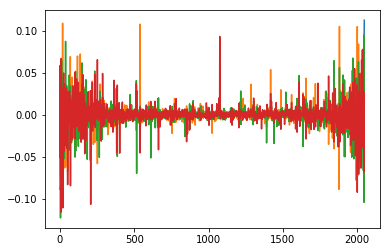

In [52]:
import matplotlib.pyplot as plt

coef_2_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_1,inside_qout_feature,C=0.0005)
coef_2_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_1,inside_qout_feature,C=0.0005)
coef_2_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_1,inside_qout_feature,C=0.0005)
coef_2_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_1,inside_qout_feature,C=0.0005)

sort_index = np.argsort(coef_2_1)
plt.plot(np.arange(len(coef_2_1)),coef_2_1[sort_index],np.arange(len(coef_2_1)),coef_2_2[sort_index],
         np.arange(len(coef_2_1)),coef_2_3[sort_index],np.arange(len(coef_2_1)),coef_2_4[sort_index])

plt.show()

In [ ]:
import matplotlib.pyplot as plt

coef_2_1 = evaluate_a_fold([1,2,3],[4],LSTM_embeddings_M_01,inside_qout_feature,C=0.00001)
coef_2_2 = evaluate_a_fold([2,3,4],[1],LSTM_embeddings_M_01,inside_qout_feature,C=0.00001)
coef_2_3 = evaluate_a_fold([1,3,4],[2],LSTM_embeddings_M_01,inside_qout_feature,C=0.00001)
coef_2_4 = evaluate_a_fold([1,2,4],[3],LSTM_embeddings_M_01,inside_qout_feature,C=0.00001)

sort_index = np.argsort(coef_2_1)
plt.plot(np.arange(len(coef_2_1)),coef_2_1[sort_index],np.arange(len(coef_2_1)),coef_2_2[sort_index],
         np.arange(len(coef_2_1)),coef_2_3[sort_index],np.arange(len(coef_2_1)),coef_2_4[sort_index])

plt.show()

In [ ]:
for block_id in [1,2,3,4]:
    if scan in block_scan['block_id']:
        if scan.step in inside_qout_indexes:
            print(scan.all_words)

In [ ]:
def get_fold_scan_object(embedding_step_dic,scan_objects,blocks):
    
    embeddings = []
    brains = []
    
    
    for block_id in blocks:
        print("len: ", len( scan_objects[block_id]))
        for scan_obj in scan_objects[block_id]:
            related_embeddings = []
            i = 0
            while i < 4 and (scan_obj.step+i - scan_objects[block_id][0].step) < len(embedding_step_dic[block_id]):
                related_embeddings.append(embedding_step_dic[block_id][scan_obj.step+i - scan_objects[block_id][0].step])
                
                i += 1
            while len(related_embeddings) < 4:
                related_embeddings.append(np.zeros_like(related_embeddings[-1]))
            averaged_embeddings = np.concatenate(related_embeddings,axis=0)#np.mean(related_embeddings,axis=0)
            embeddings.append(averaged_embeddings)
            brains.append(scan_obj.activations[0])
    return embeddings,brains
            
            

def evaluate_a_fold_brain_predictions(train_blocks, test_blocks,inputs,scan_objects,C=0.0001):
    x_train, y_train = get_fold_scan_object(inputs,labels,train_blocks)
    x_test, y_test = get_fold_scan_object(inputs,labels,test_blocks)

    clf = SVC(kernel='linear', C=C)
    clf.fit(x_train, y_train)

    prediction_train = clf.predict(x_train)
    prediction_test = clf.predict(x_test)

    train_accuracy = np.mean(y_train == prediction_train)
    test_accuracy = np.mean(y_test == prediction_test)

    print("train accuracy: ",train_accuracy, " test accuracy: ",test_accuracy)
    cnf_matrix = confusion_matrix(y_test, prediction_test)
    print(cnf_matrix)
    
    return clf.coef_[0]

def test_model(model,X_t,y_t):
    #X_t = sm.add_constant(X_t) ## let's add an intercept (beta_0) to our model
    print(X_t.shape)
    pred_t = model.predict(X_t)
    
    print(pred_t.shape)
    
    argmax_accuracy = np.mean(np.argmax(pred_t, axis=1) == np.argmax(y_t,axis=1))
    print("check argmax dim:",np.argmax(pred_t, axis=1).shape)
    print("argmax accuracy:",argmax_accuracy)
    cosine_dists = distance.cdist(pred_t,y_t,'cosine')
    euc_dists =  distance.cdist(pred_t,y_t,'euclidean')
    
    print("cosine dist >>")
    mean_ranks_c = MRR(cosine_dists)
    
    print("euc_dists dist >>")
    mean_ranks_e = MRR(euc_dists)
    
    print("binary accuracy >>")
    c_acc, e_acc, _,_ = eval(cosine_dists,euc_dists)
    print(c_acc,e_acc)
    
    return c_acc, e_acc, argmax_accuracy


def MRR(distances):
    prec_at_corrects = []
    ranks = []
    sorted_indexes = np.argsort(distances,axis=1)
    for i in np.arange(len(distances)):
        #print(i)
        correct_at = np.where(sorted_indexes[i] == i)[0] + 1
        #print("Reciprocal Rank",correct_at)
        prec_at_correct = 1.0/correct_at
        #print("precision at ",correct_at,": ",prec_at_correct)
        prec_at_corrects.append(prec_at_correct)
        ranks.append(correct_at)
    
    print("MRR: ",np.mean(prec_at_corrects)," ",np.mean(ranks))
    return np.mean(ranks), np.mean(prec_at_corrects), ranks,prec_at_corrects

def eval(dists,e_dists):
    nn_index = np.argmin(dists,axis=1)
    accuracy_on_test = np.mean(nn_index == np.argmax(np.eye(dists.shape[0]),axis=1))


    b_acc = []
    e_b_acc = []
    for i,j in itertools.combinations(np.arange(dists.shape[0]), 2):
        right_match = dists[i,i] + dists[j,j]
        wrong_match = dists[i,j] + dists[j,i]
        b_acc.append(right_match < wrong_match)

        e_right_match = e_dists[i,i] + e_dists[j,j]
        e_wrong_match = e_dists[i,j] + e_dists[j,i]
        e_b_acc.append(e_right_match < e_wrong_match)

    #print("binary accuracy: ", np.mean(b_acc)," ", np.mean(e_b_acc))
    return np.mean(b_acc),np.mean(e_b_acc),b_acc,e_b_acc

In [ ]:
print(len(LSTM_embeddings_H_0[4]))

In [ ]:
print(len(block_scans.item()[1]))

for scan in block_scans.item()[1]:
    print(scan.step)

In [ ]:
embeddings_train , brains_train = get_fold_scan_object(LSTM_embeddings_H_0,block_scans.item(),[1,2,3])
embeddings_test , brains_test = get_fold_scan_object(LSTM_embeddings_H_0,block_scans.item(),[4])

print("embedding shape",np.asarray(embeddings_train).shape)
print("brains shape",np.asarray(brains_train).shape)

import statsmodels.api as sm # import statsmodels 

reg = MLPRegressor(hidden_layer_sizes=(100,),  activation='identity', solver='adam',    alpha=0.001,batch_size='auto',
               learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
               random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9,
               nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
               epsilon=1e-08)

model = reg.fit(embeddings_train, brains_train)#sm.OLS(np.asarray(brains_train),np.asarray(embeddings_train)).fit()
test_model(model,np.asarray(embeddings_test),np.asarray(brains_test))

In [ ]:
embeddings_train , brains_train = get_fold_scan_object(LSTM_embeddings_H_01,block_scans.item(),[1,2,3])
embeddings_test , brains_test = get_fold_scan_object(LSTM_embeddings_H_01,block_scans.item(),[4])

print("embedding shape",np.asarray(embeddings_train).shape)
print("brains shape",np.asarray(brains_train).shape)

import statsmodels.api as sm # import statsmodels 

delay = 0
length = len(brains_train)
model = sm.OLS(np.tanh(np.asarray(brains_train))[:length - delay],np.asarray(embeddings_train)[delay:]).fit()
test_model(model,np.asarray(embeddings_test)[delay:],np.tanh(np.asarray(brains_test))[:length - delay])

In [ ]:
np.tanh(brains_train)

In [ ]:
embeddings_train , brains_train = get_fold_scan_object(LSTM_embeddings_H_01,block_scans.item(),[1,2,3])
embeddings_test , brains_test = get_fold_scan_object(LSTM_embeddings_H_01,block_scans.item(),[4])

print("embedding shape",np.asarray(embeddings_train).shape)
print("brains shape",np.asarray(brains_train).shape)

import statsmodels.api as sm # import statsmodels 

model = sm.OLS(np.asarray(brains_train),np.asarray(embeddings_train)).fit()
test_model(model,np.asarray(embeddings_test),np.asarray(brains_test))

In [ ]:
embeddings_train , brains_train = get_fold_scan_object(LSTM_embeddings_M_01,block_scans.item(),[1,2,3])
embeddings_test , brains_test = get_fold_scan_object(LSTM_embeddings_M_01,block_scans.item(),[4])

print("embedding shape",np.asarray(embeddings_train).shape)
print("brains shape",np.asarray(brains_train).shape)

import statsmodels.api as sm # import statsmodels 

model = sm.OLS(np.asarray(brains_train),np.asarray(embeddings_train)).fit()
test_model(model,np.asarray(embeddings_test),np.asarray(brains_test))

In [ ]:
def fold_brain_features(block_features, block_scans, block_ids):
    brains = []
    features = []
    for block_id in block_ids:
        for scan in block_scans.item()[block_id]:
            block_step = scan.step  - block_scans.item()[block_id][0].step
            brains.append(scan.activations[0])

            related_features = []
            i = 0
            while i<4 and (block_step + i) < len(block_features[block_id]):
                related_features.append(block_features[block_id][block_step + i])
                i += 1

            features.append(max(related_features))  
    
    print(len(features),len(brains))
    brains = np.asarray(brains)
    brains = (brains - np.min(brains,axis=0))/(np.max(brains,axis=0) - np.min(brains,axis=0) + 0.000001)
    return brains, features     


def evaluate_fold_brain_features(feature_model, block_scans,test_blocks,train_blocks):
    brains_train, features_train = fold_brain_features(feature_model,block_scans,block_ids=train_blocks)
    brains_test, features_test = fold_brain_features(feature_model,block_scans,block_ids=test_blocks)


    clf = SVC(kernel='linear',class_weight='balanced', C=0.001)
    clf.fit(brains_train, features_train)

    prediction_train = clf.predict(brains_train)
    prediction_test = clf.predict(brains_test)

    train_accuracy = np.mean(features_train == prediction_train)
    test_accuracy = np.mean(features_test == prediction_test)

    print("train accuracy: ",train_accuracy, " test accuracy: ",test_accuracy)
    cnf_matrix = confusion_matrix(features_test, prediction_test)
    print(cnf_matrix)

How well we can predict inside qoat from the brain data:

In [ ]:
evaluate_fold_brain_features(inside_qout_feature,block_scans,[1],[2,3,4])
evaluate_fold_brain_features(inside_qout_feature,block_scans,[2],[1,3,4])
evaluate_fold_brain_features(inside_qout_feature,block_scans,[3],[1,2,4])
evaluate_fold_brain_features(inside_qout_feature,block_scans,[4],[1,2,3])

In [ ]:
evaluate_fold_brain_features(start_sentence_feature,block_scans,[1],[2,3,4])
evaluate_fold_brain_features(start_sentence_feature,block_scans,[2],[1,3,4])
evaluate_fold_brain_features(start_sentence_feature,block_scans,[3],[1,2,4])
evaluate_fold_brain_features(start_sentence_feature,block_scans,[4],[1,2,3])

In [ ]:
evaluate_fold_brain_features(end_sentence_feature,block_scans,[1],[2,3,4])
evaluate_fold_brain_features(end_sentence_feature,block_scans,[2],[1,3,4])
evaluate_fold_brain_features(end_sentence_feature,block_scans,[3],[1,2,4])
evaluate_fold_brain_features(end_sentence_feature,block_scans,[4],[1,2,3])

In [ ]:
evaluate_fold_brain_features(end_sentence_feature,block_scans,[1],[2,3,4])
evaluate_fold_brain_features(end_sentence_feature,block_scans,[2],[1,3,4])
evaluate_fold_brain_features(end_sentence_feature,block_scans,[3],[1,2,4])
evaluate_fold_brain_features(end_sentence_feature,block_scans,[4],[1,2,3])

In [80]:
block_scans[1][0].activations.shape

(1, 37913)